<h1>Analysis strategy</h1>

<h3>General anaylsis idea</h3>

I tried to predict after how many cycles the capacity drop hits the 0.3 threshold (battery longevity has dropped to 70 %). Ordering a new battery and charging it for the next dance would equate to 22 days. Assuming a robot charges once per day I'd have recommended to change the battery 30 charging cycles before the drop is predicted to hit the threshold, to give it a bit of a buffer.

<h3>Analysis steps</h3>

<h4>Exploratory data analysis</h4>

We have three metric (number of charging cycle, battery life and charging time) and one binary predictor (FullCharge). The variable we are trying to predict is metric. I plotted the data and found the capacity drop shows a fast increase in the beginning but then significantly slows down over time until it almost hits a platue. 
I also calculated the correlations between the variables and found that only battery life has a significant correlation with capacity drop. I used a spearman rank correlation because the variables are not normally distributed.

<h4>Compare the fit of different models against each other</h4>

In my initial comparison I used a couple of commonly used models to see how they fit. Here the Random Forest and XGBoost models seemed the best choice. I then tried to find the best parameter settings for each model using CVGrid.

<h4>Simulate data for further testing</h4>

To be able to predict when the threshold would be crossed I simulated data on the basis of the file provided to me. In the simulation I kept correlations within the data and put constrains on it, namely that the values can never be negative and that the value of FullCharge always either has to be a 0 or 1.

<h4>Test the models on the simulated data</h4>

I tried to test the models by using the simulated data. Here I found that the predictions from both Random Forest and XGBoost did not cross the biggest value present in the data the models were trained on. After further research, the models seem to be bad/unable to predict values the didn't see before in training. Therefore, I tried a polynomial regresssion, which showed a (suspiciously) high fit. When it came to predicting the threshold crossing in the simulated data, the prediction showed a such high variability that any prediction would be unreliable.

<h1>Conclusion</h1>

I would not yet make a prediction for the appointment. Rather I would go back and gather further information.

- Is there any data of a battery that has crossed the 0.3 threshold.
- What would be expected failure times due to domain knowledge?
- What is the cost of switching a battery and what is the penality for having less than 70% longevity at the end of the dance battle? To see whether the risk is worth it.
- What exactly is the probability that the robot will be checked after the dance battle?
- What exactly does a wildcard allow a robot to do?
- What is the unit of BatteryLife? For ChargingTime it is defined as hours, is this also the case for the battery life?

After gathering answers for these questions I would go back to the analysis and repeat it again.

In [206]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from scipy.stats import rankdata, norm
from numpy.random import multivariate_normal
from sklearn.preprocessing import PolynomialFeatures
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from scipy.optimize import curve_fit
from sklearn.isotonic import IsotonicRegression

models = {
    "Random Forest": RandomForestRegressor(),
    "Linear Regression": LinearRegression(),
    "SVR": SVR(),
    "XGBoost": XGBRegressor(),
    "Neural Net": MLPRegressor()
}


robo_data = pd.read_csv(r"C:\Users\lisar\Downloads\Ascent DS Challenge Data set.csv")

minmaxscaler = MinMaxScaler()
robo_data[["ChargingTime_minmax", "BatteryLife_minmax"]] = minmaxscaler.fit_transform(robo_data[["ChargingTime", "BatteryLife"]])


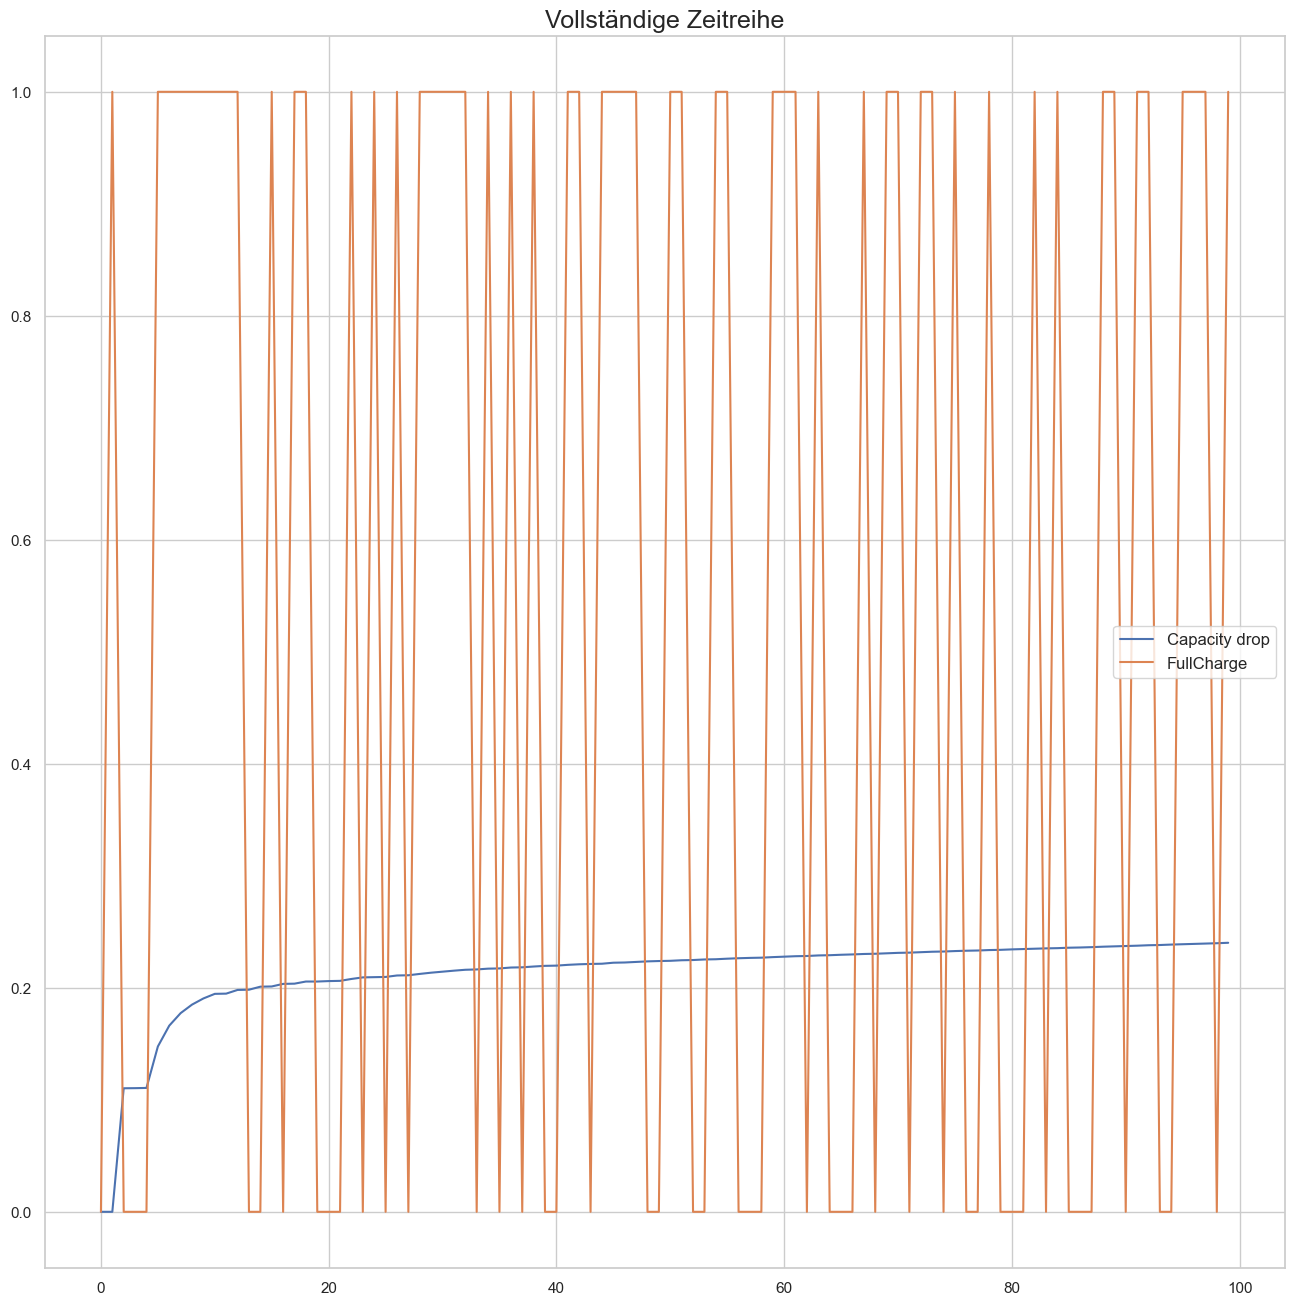

In [207]:
df_ts = robo_data[["Capacity drop", 'FullCharge']].copy()
fig = df_ts.plot(kind='line')
plt.title('Vollständige Zeitreihe', size=18)
plt.legend(fontsize=12)
plt.show()

In [208]:
robo_data["Capacity drop_shifted"] = robo_data["Capacity drop"].shift(1)
robo_data["Capacity drop_diff"] = robo_data["Capacity drop"] - robo_data["Capacity drop_shifted"]
robo_data

,ChargingTime,FullCharge,BatteryLife,Capacity drop,ChargingTime_minmax,BatteryLife_minmax,Capacity drop_shifted,Capacity drop_diff
0,2.81,0,5.6200,0.0000,0.239761,0.702500,NaN,NaN
1,7.14,1,8.0000,0.0000,0.609215,1.000000,0.0000,0.0000
2,2.72,0,5.4400,0.1103,0.232082,0.680000,0.0000,0.1103
3,3.87,0,7.1165,0.1104,0.330205,0.889563,0.1103,0.0001
4,1.90,0,3.8000,0.1106,0.162116,0.475000,0.1104,0.0002
...,...,...,...,...,...,...,...,...
95,4.38,1,6.0892,0.2389,0.373720,0.761150,0.2386,0.0003
96,8.06,1,6.0864,0.2392,0.687713,0.760800,0.2389,0.0003
97,8.05,1,6.0836,0.2395,0.686860,0.760450,0.2392,0.0003
98,1.10,0,2.2000,0.2398,0.093857,0.275000,0.2395,0.0003


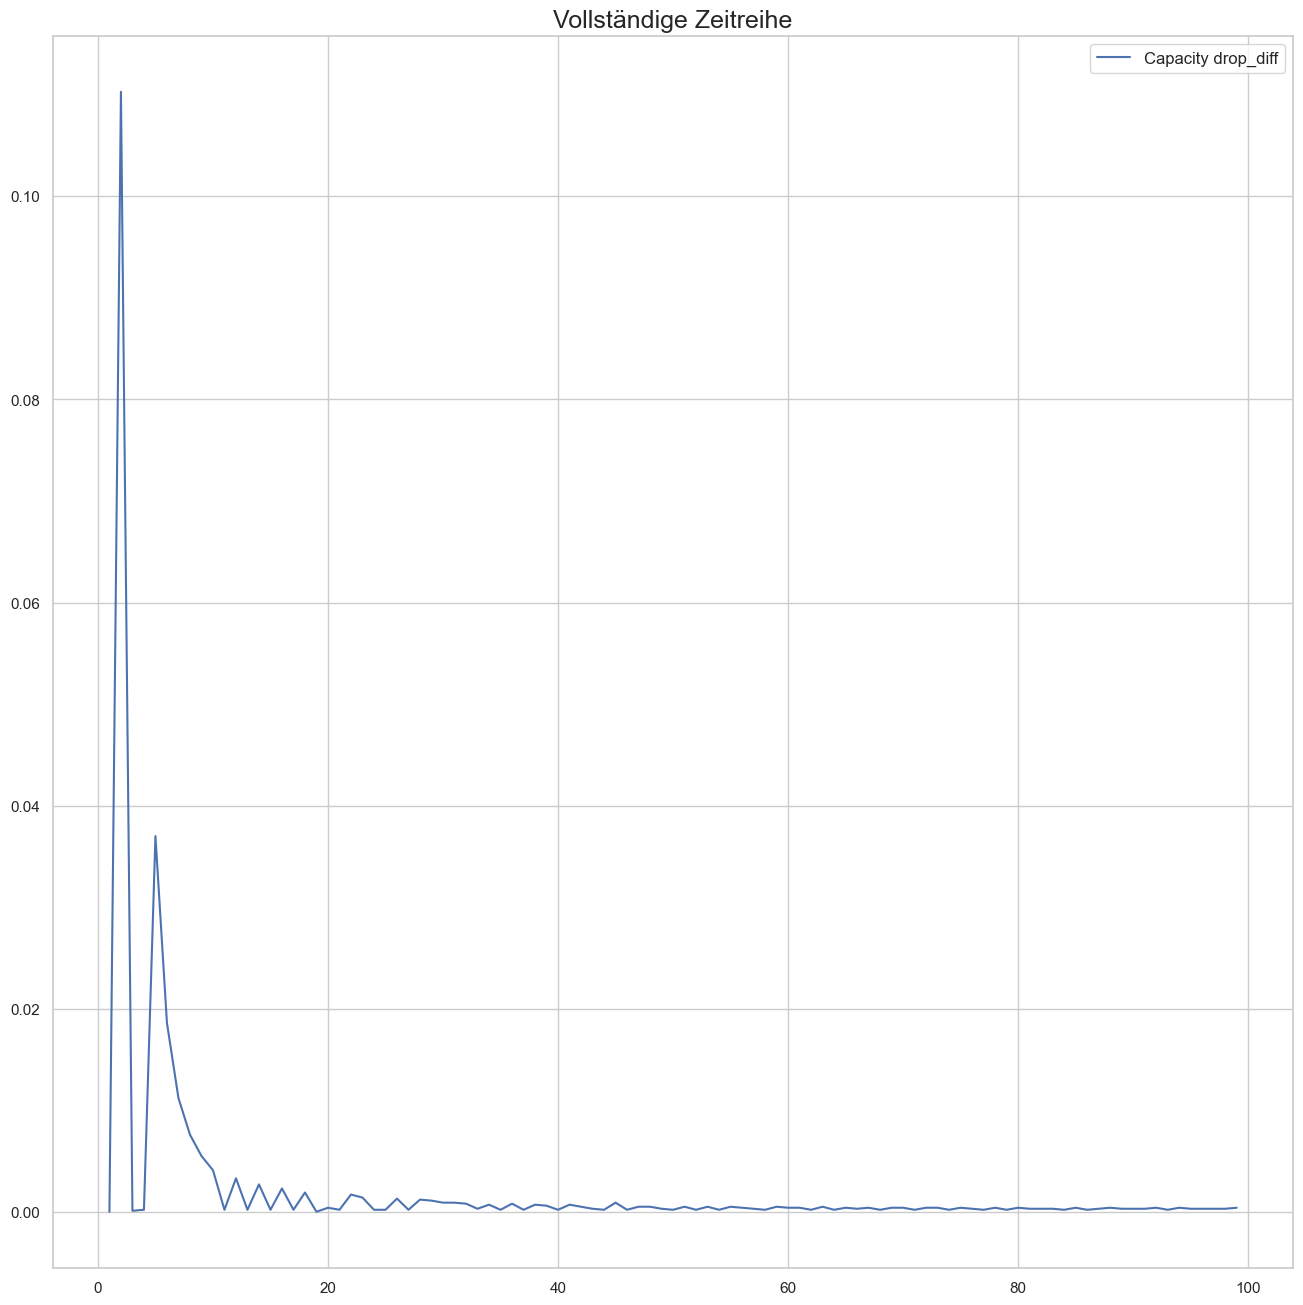

In [209]:
df_ts = robo_data[['Capacity drop_diff']].copy()
fig = df_ts.plot(kind='line')
plt.title('Vollständige Zeitreihe', size=18)
plt.legend(fontsize=12)
plt.show()

<Axes: ylabel='Density'>

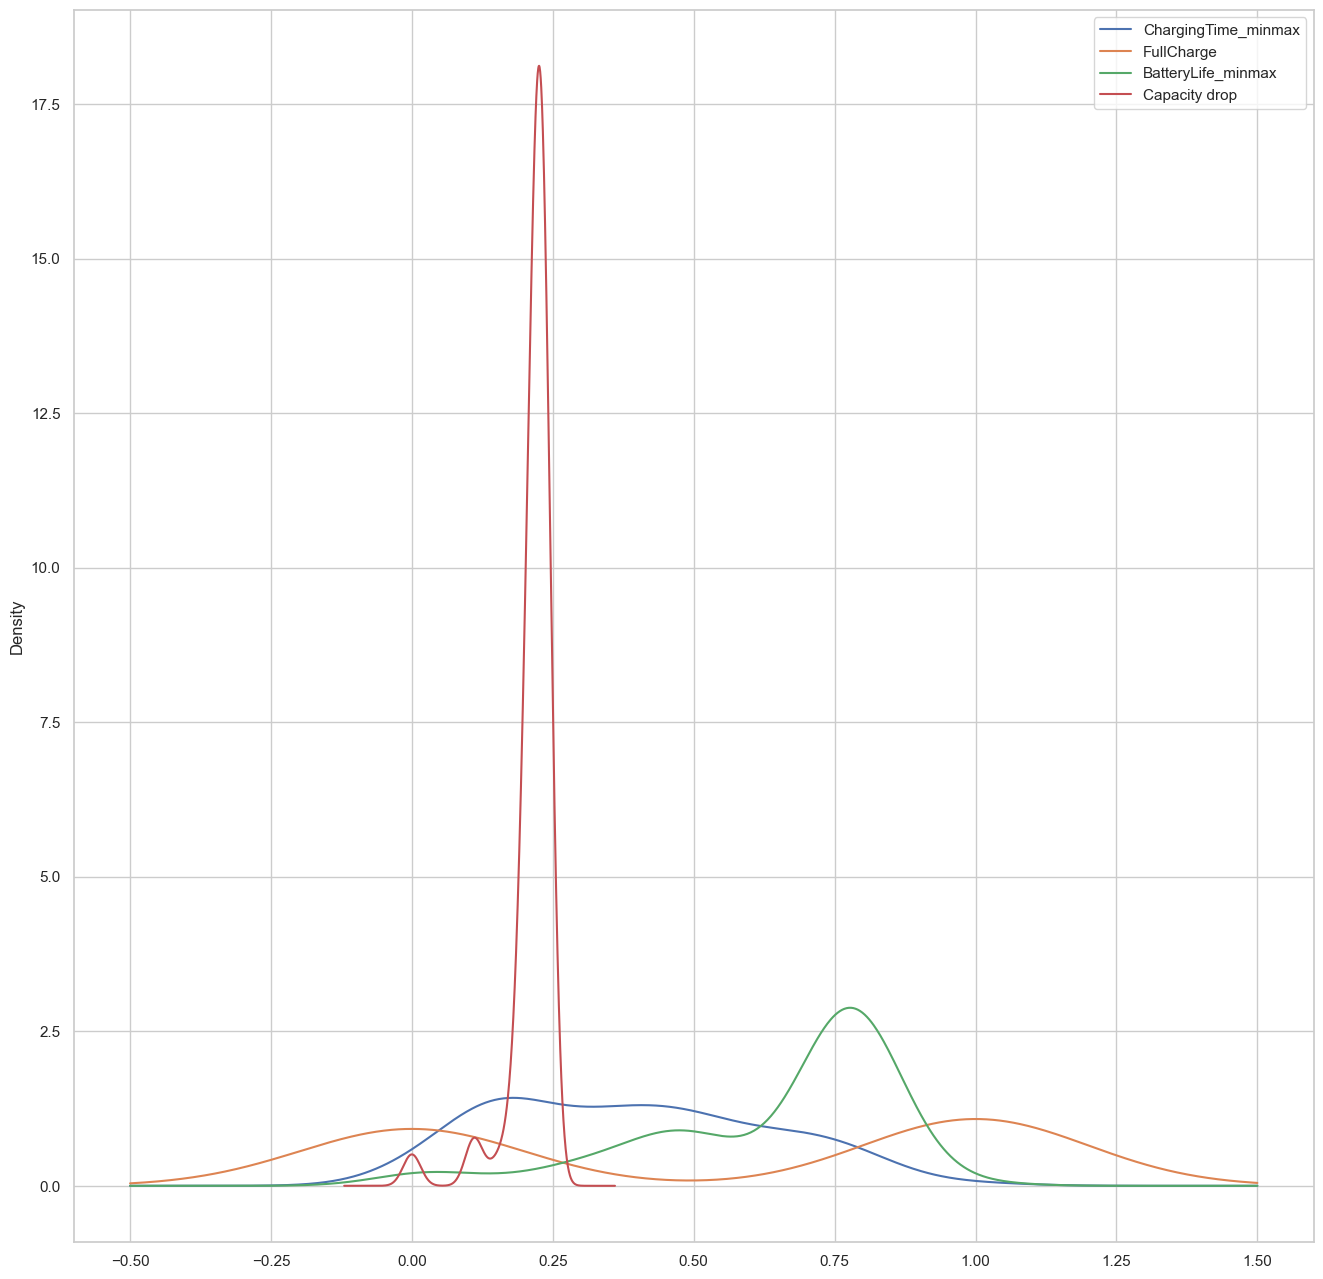

In [210]:
int_data = robo_data[["ChargingTime_minmax", "FullCharge", "BatteryLife_minmax", "Capacity drop"]].copy()
int_data.plot.kde()

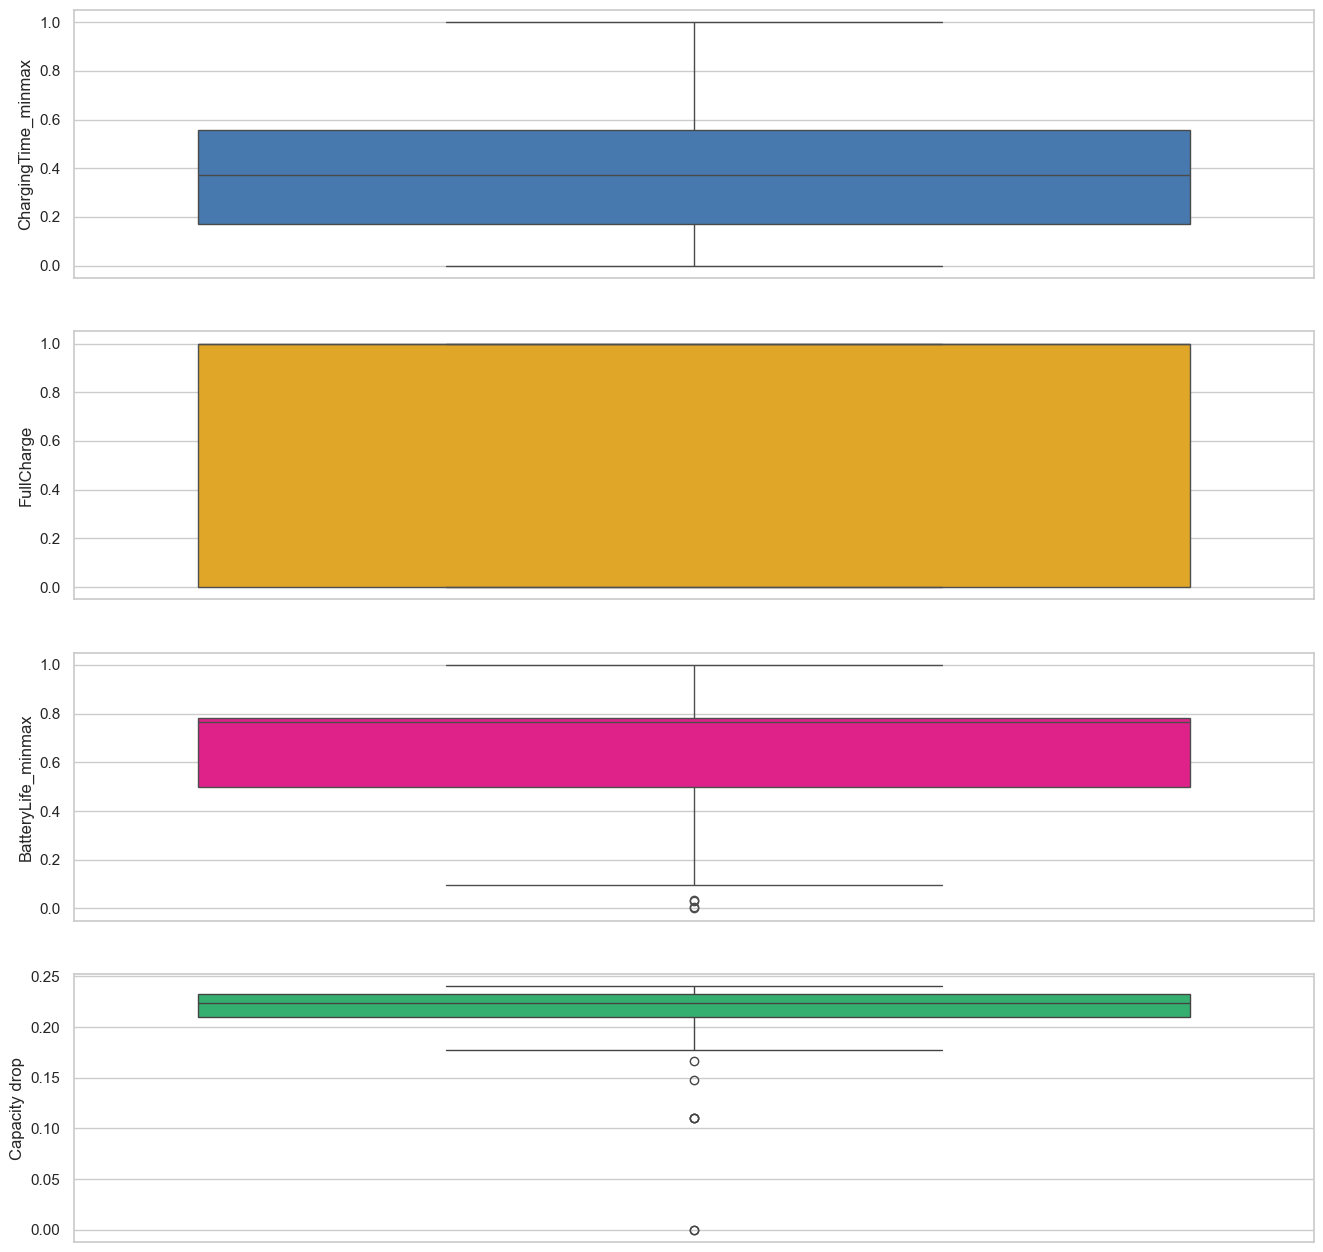

In [211]:
plt.rcParams['figure.figsize'] = [16, 16]
my_colors = ["windows blue", "saffron", "hot pink", "algae green", "dusty purple", "greyish", "petrol", "denim blue", "lime"]
sns.set_palette(sns.xkcd_palette(my_colors))
colors = sns.xkcd_palette(my_colors)
fig, axs = plt.subplots(4, 1)
sns.boxplot(int_data.iloc[:,0], color=colors[0], ax=axs[0])
sns.boxplot(int_data.iloc[:,1], color=colors[1], ax=axs[1])
sns.boxplot(int_data.iloc[:,2], color=colors[2], ax=axs[2])
sns.boxplot(int_data.iloc[:,3], color=colors[3], ax=axs[3])
plt.show()

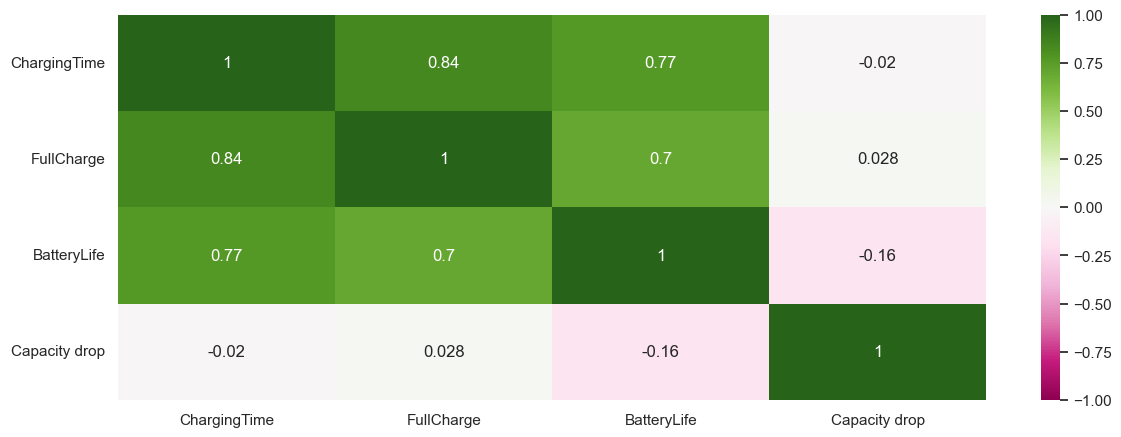

In [212]:
pred_data = robo_data[["ChargingTime", "FullCharge", "BatteryLife", "Capacity drop"]].copy()
plt.figure(figsize=(14,5))
sns.heatmap(pred_data.corr(), vmin=-1, cmap='PiYG', annot=True)
plt.yticks(rotation=0)
plt.show()

#Predictors are highly correlated

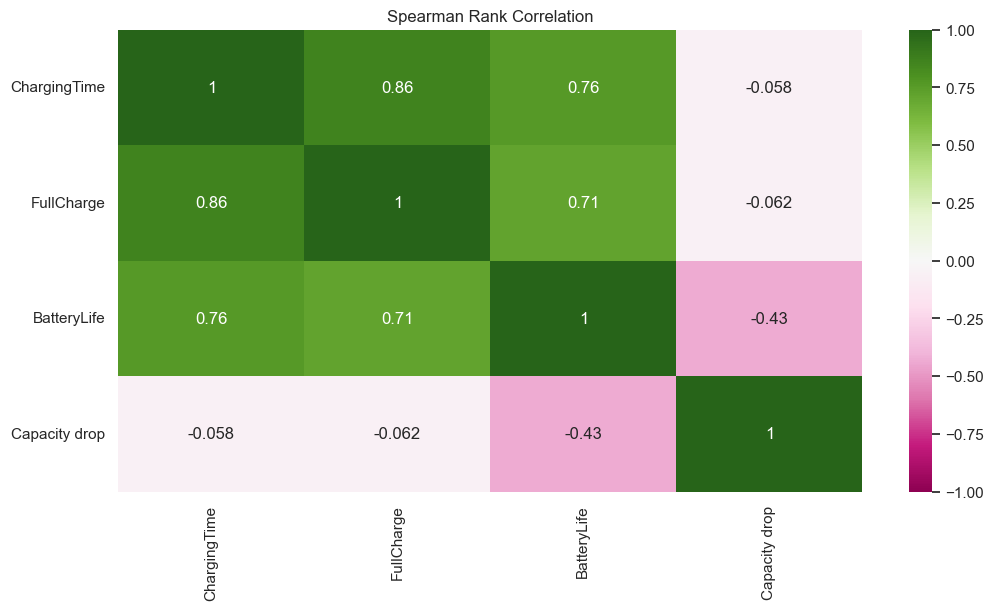

In [213]:
plt.figure(figsize=(12,6))
plt.title('Spearman Rank Correlation')
sns.heatmap(pred_data.corr(method='spearman'), vmin=-1,cmap='PiYG', annot=True)
plt.yticks(rotation=0)
plt.xticks(rotation=90)
plt.show()

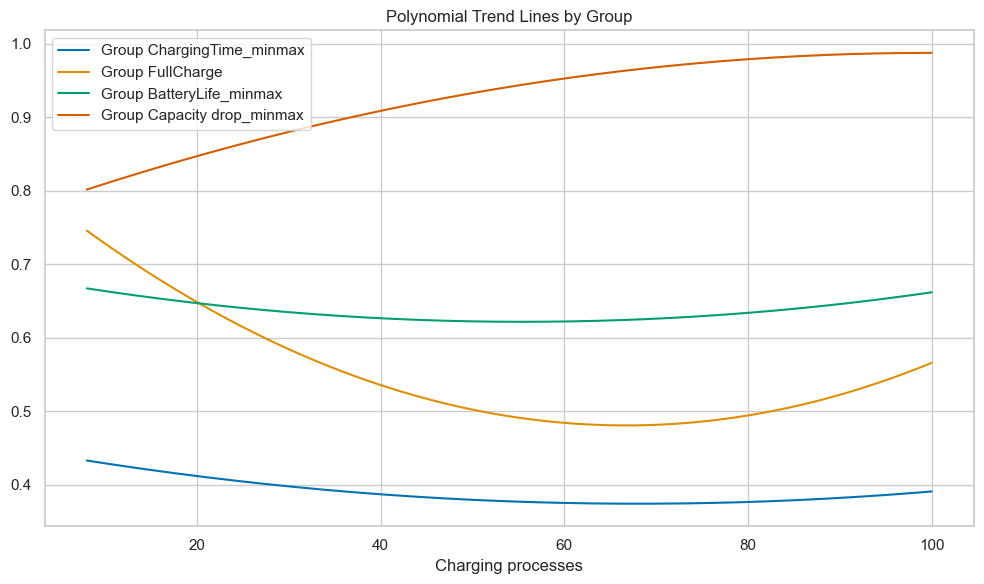

In [214]:
# Set plot style
sns.set(style="whitegrid")
# Plot polynomial trend lines for each group
plt.figure(figsize=(10, 6))
colors = sns.color_palette("colorblind", len(df_long["variable"].unique()))
#colors = sns.set_palette("colorblind")

for i, group in enumerate(df_long["variable"].unique()):
    group_data = df_long[df_long['variable'] == group]
    x = group_data['cycle'].values.reshape(-1, 1)
    y = group_data['value'].values
    model = make_pipeline(PolynomialFeatures(degree=2), LinearRegression())
    model.fit(x, y)
    x_plot = np.linspace(x.min(), x.max(), 200).reshape(-1, 1)
    y_plot = model.predict(x_plot)
    plt.plot(x_plot, y_plot, label=f'Group {group}', color=colors[i])

plt.title('Polynomial Trend Lines by Group')
plt.xlabel('Charging processes')
plt.legend()
plt.tight_layout()
plt.show()

In [215]:
#Testing different models for best fit
robo_data["cycle"] = robo_data.index + 1

features = ['ChargingTime_minmax', 'BatteryLife_minmax', 'FullCharge', 'cycle']
X = robo_data[features]
y = robo_data['Capacity drop']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

for name, model in models.items():
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    rmse_scores = np.sqrt(-scores)
    print(f"{name}: Mean RMSE = {rmse_scores.mean():.2f}, Std = {rmse_scores.std():.2f}")

print(f"\nGet best model\n")

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"{name} — MAE: {mean_absolute_error(y_test, y_pred):.2f}, R²: {r2_score(y_test, y_pred):.2f}") 


Random Forest: Mean RMSE = 0.01, Std = 0.02
Linear Regression: Mean RMSE = 0.02, Std = 0.01
SVR: Mean RMSE = 0.09, Std = 0.01
XGBoost: Mean RMSE = 0.02, Std = 0.01
Neural Net: Mean RMSE = 1.06, Std = 0.48

Get best model

Random Forest — MAE: 0.01, R²: 0.76
Linear Regression — MAE: 0.03, R²: 0.38
SVR — MAE: 0.09, R²: -2.05
XGBoost — MAE: 0.01, R²: 0.79
Neural Net — MAE: 1.56, R²: -968.22


In [216]:
#Identify ideal parameter for the model

param_grid = {
    "max_depth": [3, 5, 7],
    "learning_rate": [0.01, 0.1, 0.2],
    "n_estimators": [100, 300],
    "subsample": [0.8, 1.0]
}

# Train the model
reduction_model = XGBRegressor()
grid_search = GridSearchCV(reduction_model, param_grid, cv=3, scoring="neg_mean_squared_error")
grid_search.fit(X_train, y_train)
print(grid_search.best_params_)


{'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 300, 'subsample': 0.8}


In [217]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

rf = RandomForestRegressor(random_state=42)

grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=2
)

grid_search.fit(X_train, y_train)


Fitting 5 folds for each of 324 candidates, totalling 1620 fits


c:\Users\lisar\ascent_challange\Lib\site-packages\sklearn\model_selection\_validation.py:516: FitFailedWarning: 
540 fits failed out of a total of 1620.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
343 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\lisar\ascent_challange\Lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\lisar\ascent_challange\Lib\site-packages\sklearn\base.py", line 1358, in wrapper
    estimator._validate_params()
  File "c:\Users\lisar\ascent_challange\Lib\site-packages\sklearn\base.py", line 471, in _validate_params
    validate_parameter_constraints(
  File "c:\Users\li

,estimator,RandomForestR...ndom_state=42)
,param_grid,"{'max_depth': [None, 10, ...], 'max_features': ['auto', 'sqrt', ...], 'min_samples_leaf': [1, 2, ...], 'min_samples_split': [2, 5, ...], ...}"
,scoring,'neg_mean_squared_error'
,n_jobs,-1
,refit,True
,cv,5
,verbose,2
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_estimators,100


In [218]:
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)


Best Parameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best Score: -0.0003349788426548868


<H2>Simulating data</H2>

In [219]:
fullcharge_probs = robo_data['FullCharge'].value_counts(normalize=True)
sim_fullcharge = np.random.choice([0, 1], size=200, p=[fullcharge_probs[0], fullcharge_probs[1]])

from sklearn.neighbors import KernelDensity

# Split original data by FullCharge
df_0 = robo_data[robo_data['FullCharge'] == 0][['BatteryLife', 'ChargingTime']]
df_1 = robo_data[robo_data['FullCharge'] == 1][['BatteryLife', 'ChargingTime']]

# Fit KDE models
kde_0 = KernelDensity(kernel='gaussian', bandwidth=0.1).fit(df_0)
kde_1 = KernelDensity(kernel='gaussian', bandwidth=0.1).fit(df_1)

# Simulate BatteryLife and ChargingTime based on FullCharge
sim_bl_ct = []
for fc in sim_fullcharge:
    kde = kde_1 if fc == 1 else kde_0
    sample = kde.sample(1)
    sim_bl_ct.append(sample[0])

sim_bl_ct = np.array(sim_bl_ct)

battery_min, battery_max = robo_data['BatteryLife'].min(), robo_data['BatteryLife'].max()
charging_min, charging_max = robo_data['ChargingTime'].min(), robo_data['ChargingTime'].max()

sim_bl_ct[:, 0] = np.clip(sim_bl_ct[:, 0], battery_min, battery_max)
sim_bl_ct[:, 1] = np.clip(sim_bl_ct[:, 1], charging_min, charging_max)


future_df = pd.DataFrame({
    'FullCharge': sim_fullcharge,
    'ChargingTime': sim_bl_ct[:, 1],
    'BatteryLife': sim_bl_ct[:, 0],
    
})

future_df["cycle"] = future_df.index +1 
future_df[["ChargingTime_minmax", "BatteryLife_minmax"]] = minmaxscaler.fit_transform(future_df[["ChargingTime", "BatteryLife"]])

<Axes: ylabel='Density'>

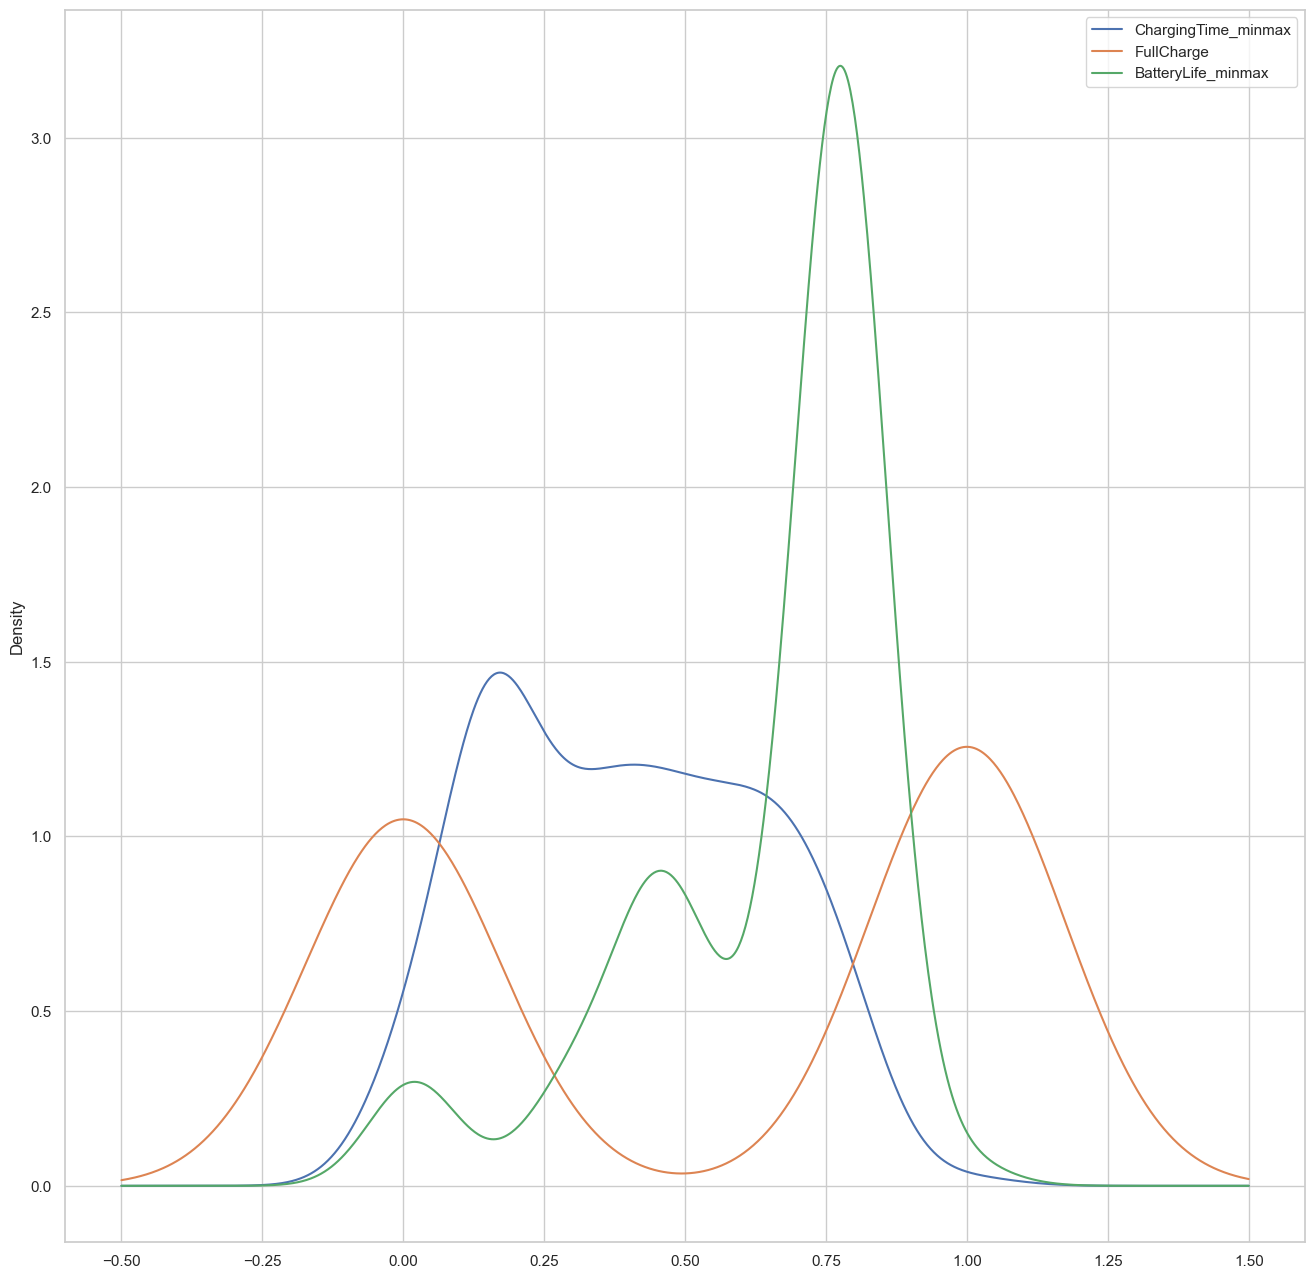

In [220]:
int_data = future_df[["ChargingTime_minmax", "FullCharge", "BatteryLife_minmax"]].copy()
int_data.plot.kde()

#Simulated data looks close to actual data

In [221]:
future_df

,FullCharge,ChargingTime,BatteryLife,cycle,ChargingTime_minmax,BatteryLife_minmax
0,0,1.844597,3.847111,1,0.157701,0.480889
1,0,1.777475,3.706442,2,0.151963,0.463305
2,0,1.584441,3.086943,3,0.135460,0.385868
3,1,9.414120,6.133679,4,0.804848,0.766710
4,0,1.711578,3.595401,5,0.146329,0.449425
...,...,...,...,...,...,...
195,1,4.963448,6.487767,196,0.424344,0.810971
196,1,5.649047,6.221743,197,0.482958,0.777718
197,1,6.713900,6.616140,198,0.573996,0.827018
198,1,6.626019,6.148313,199,0.566483,0.768539


In [222]:
constraints = (-1, 1)

xgb_model = XGBRegressor(objective='reg:squarederror', monotone_constraints=constraints, learning_rate=0.02, max_depth=3, n_estimators=100, subsample=0.8)
xgb_model.fit(X_train, y_train)
xgb_preds = xgb_model.predict(X_test)

poly_model = make_pipeline(PolynomialFeatures(degree=2), LinearRegression())
poly_model.fit(X_train, y_train)
poly_preds = poly_model.predict(X_test)

kernel = C(1.0) * RBF(length_scale=1.0)
gpr_model = GaussianProcessRegressor(kernel=kernel, alpha=1e-2)
gpr_model.fit(X_train, y_train)
gpr_preds = gpr_model.predict(X_test)

random_forest_model = RandomForestRegressor(max_depth = 10, max_features = 'sqrt', min_samples_leaf = 2, min_samples_split = 2, n_estimators = 200)
random_forest_model.fit(X_train, y_train)
random_forest_preds = random_forest_model.predict(X_test)

In [223]:
def evaluate_model(name, y_true, y_pred):
    print(f"{name} Results:")
    print(f"  MAE:  {mean_absolute_error(y_true, y_pred):.4f}")
    print(f"  RMSE: {np.sqrt(mean_squared_error(y_true, y_pred)):.4f}")
    print(f"  R²:   {r2_score(y_true, y_pred):.4f}")
    print("-" * 40)

evaluate_model("XGBoost", y_test, xgb_preds)
evaluate_model("Polynomial Regression", y_test, poly_preds)
evaluate_model("Gaussian Process", y_test, gpr_preds)
evaluate_model("Random Forest Regressor", y_test, random_forest_preds)

# XGBoost Results:
#   MAE:  0.0103
#   RMSE: 0.0315
#   R²:   0.6614
# ----------------------------------------
# Polynomial Regression Results:
#   MAE:  0.0084
#   RMSE: 0.0198
#   R²:   0.8663
# ----------------------------------------
# Gaussian Process Results:
#   MAE:  0.0173
#   RMSE: 0.0421
#   R²:   0.3934
# ----------------------------------------

XGBoost Results:
  MAE:  0.0074
  RMSE: 0.0227
  R²:   0.8230
----------------------------------------
Polynomial Regression Results:
  MAE:  0.0156
  RMSE: 0.0380
  R²:   0.5066
----------------------------------------
Gaussian Process Results:
  MAE:  0.0269
  RMSE: 0.0550
  R²:   -0.0363
----------------------------------------
Random Forest Regressor Results:
  MAE:  0.0104
  RMSE: 0.0312
  R²:   0.6678
----------------------------------------


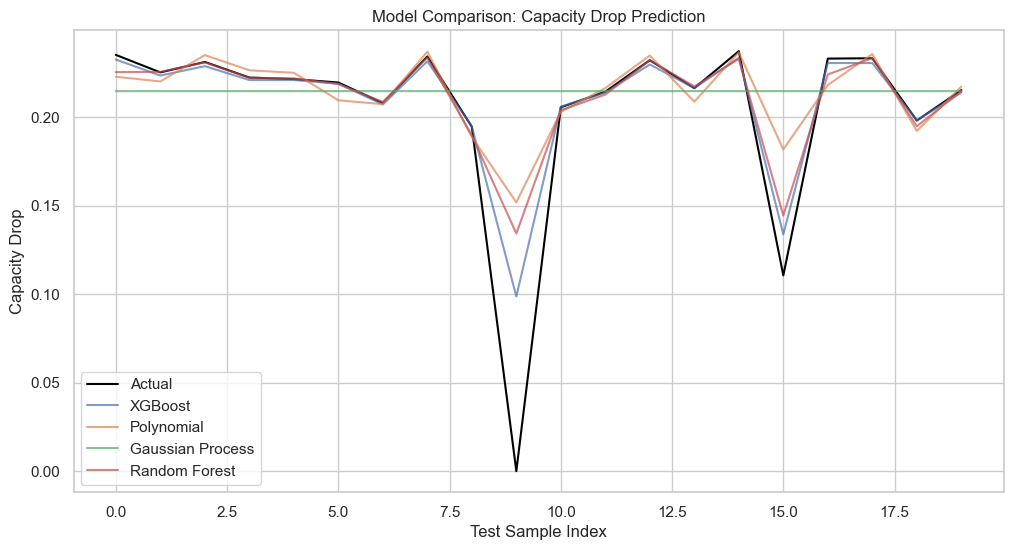

In [224]:
plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label='Actual', color='black')
plt.plot(xgb_preds, label='XGBoost', alpha=0.7)
plt.plot(poly_preds, label='Polynomial', alpha=0.7)
plt.plot(gpr_preds, label='Gaussian Process', alpha=0.7)
plt.plot(random_forest_preds, label='Random Forest', alpha=0.7)
plt.legend()
plt.title("Model Comparison: Capacity Drop Prediction")
plt.xlabel("Test Sample Index")
plt.ylabel("Capacity Drop")
plt.grid(True)
plt.show()


In [225]:
# Predict
X_future = future_df[features]

xgb_future_preds = xgb_model.predict(X_future)
poly_future_preds = poly_model.predict(X_future)
gpr_future_preds = gpr_model.predict(X_future)
forest_future_preds = random_forest_model.predict(X_future)


In [226]:
threshold = 0.3
cross_index = np.argmax(poly_future_preds >= threshold)

if cross_index > 0:
    print(f"Threshold of {threshold} will be crossed at cycle {X_future.iloc[cross_index]['cycle']}")
else:
    print("Threshold not reached in simulated range.")



Threshold not reached in simulated range.


In [227]:
poly_future_preds

array([0.17450068, 0.17723624, 0.18701211, 0.22019937, 0.18157319,
       0.16324859, 0.21340574, 0.16952696, 0.19491756, 0.20592223,
       0.22657824, 0.19159718, 0.22732426, 0.2172885 , 0.22405969,
       0.2120829 , 0.18183553, 0.17562554, 0.2432418 , 0.16842749,
       0.19608876, 0.24057191, 0.1998207 , 0.20199977, 0.2218217 ,
       0.16303859, 0.22648476, 0.18455566, 0.22451657, 0.19337829,
       0.21549468, 0.20213602, 0.2146136 , 0.23395844, 0.21267784,
       0.21468283, 0.23136835, 0.23368568, 0.19614962, 0.21693373,
       0.21240802, 0.2153622 , 0.03355757, 0.20883592, 0.22310641,
       0.20797902, 0.20932761, 0.19914168, 0.22236283, 0.22305352,
       0.20407819, 0.22882244, 0.24842496, 0.22344413, 0.23028341,
       0.23370249, 0.23611832, 0.22904883, 0.21802569, 0.21981399,
       0.22855641, 0.24021686, 0.23885738, 0.22913395, 0.21753771,
       0.23121543, 0.20232416, 0.24089473, 0.21783956, 0.23158719,
       0.2388207 , 0.23622246, 0.22536103, 0.21957485, 0.24761

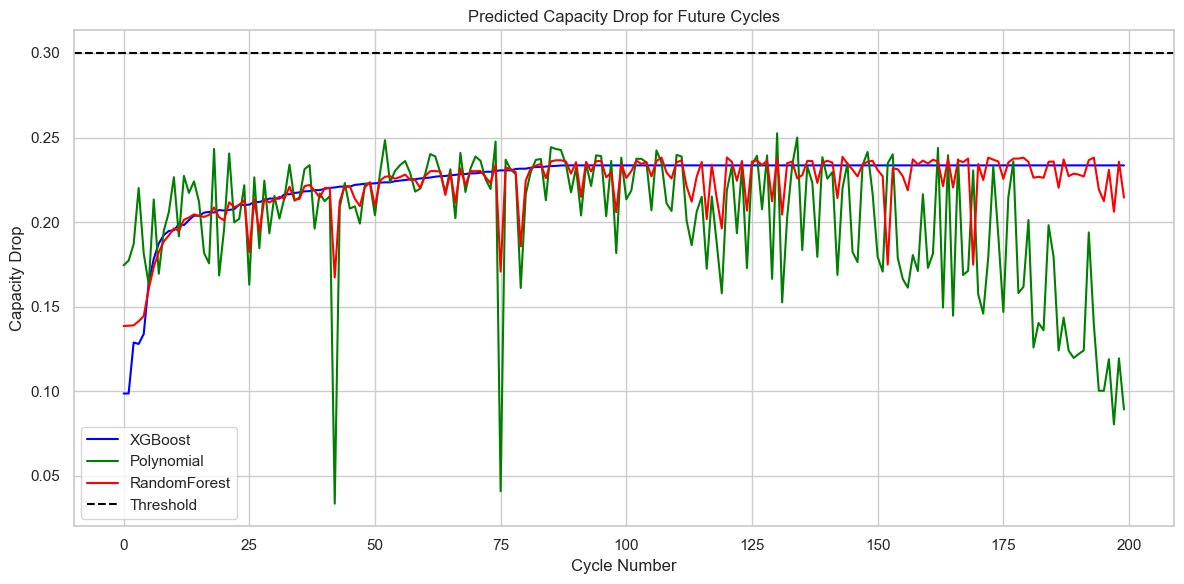

In [228]:
plt.figure(figsize=(12, 6))
plt.plot(xgb_future_preds, label='XGBoost', color='blue')
plt.plot(poly_future_preds, label='Polynomial', color='green')
plt.plot(forest_future_preds, label='RandomForest', color='red')
plt.axhline(y=0.3, color='black', linestyle='--', label='Threshold')
plt.title("Predicted Capacity Drop for Future Cycles")
plt.xlabel("Cycle Number")
plt.ylabel("Capacity Drop")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [229]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(poly_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
print("Average CV RMSE:", (-scores.mean())**0.5)


Average CV RMSE: 0.013694783701301755
